In [3]:
# %matplotlib notebook
import pandas as pd
import numpy as np

import sys
sys.path.append('Utils/')
from cycleGRN import bin_traj, train_ours,traj_ours,build_laplacian,find_Lie_derivative,time_lagged_correlation
from cycleGRN import time_lagged_Granger
from benchmark_harissa import benchmark_HARISSA

import scipy
import scanpy
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

# Load a test data (CN5 simulated by HARISSA)

In [45]:
data = pd.read_csv('Data/Data/data_1.txt',sep='\t',header=None)
print(data.shape)
t = data.iloc[0,:]
# data_cycle = data#data.iloc[[2,4,5],201:]


data = data.iloc[1:,1:]

data_cycle = data

import scanpy as sc
adata = sc.AnnData(data.T)
sc.pp.log1p(adata)


data_cycle = data


(7, 1001)


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/functools.py:934: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/functools.py:934: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)


# Visualize 2D PCA

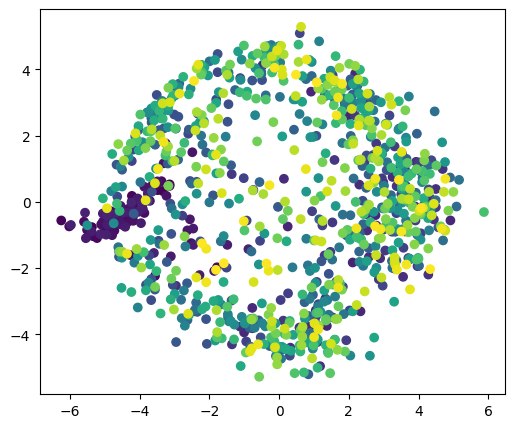

In [27]:
import scanpy as sc
plt.rcParams['figure.figsize'] = (6,5)
# Compute PCA


sc.tl.pca(adata, n_comps=2)

plt.scatter(adata.obsm["X_pca"][:,0],adata.obsm["X_pca"][:,1], c=range(adata.obsm["X_pca"][:,1].shape[0]) )
plt.show()

# if adata_cycle.X.shape[1] == 2:
#     print('only 2 genes')
#     plt.scatter(adata_cycle.X[:,0], adata_cycle.X[:,1], c=range(adata.obsm["X_pca"][:,1].shape[0]) )
#     X = adata_cycle.X
# else:
#     sc.tl.pca(adata_cycle, n_comps=2)
#     X = adata_cycle.obsm["X_pca"]
#     plt.scatter(adata_cycle.obsm["X_pca"][:,0],adata_cycle.obsm["X_pca"][:,1], c=range(adata.obsm["X_pca"][:,1].shape[0]) )

# This is our occupancy measure

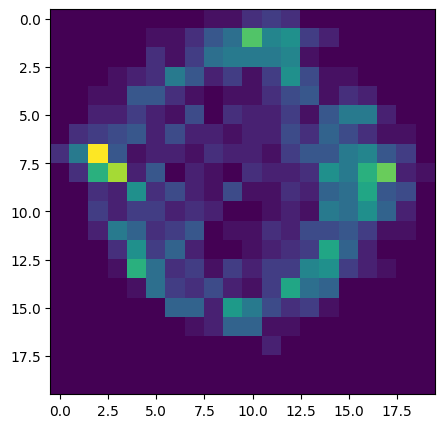

In [38]:
pca_result = adata.obsm["X_pca"]

# ys_true = (pca_result[:, [1,0]] - pca_result[:, [1,0]].min(0)) / np.ptp(pca_result[:, :2],0) * [8, 8] - [4, 4]


ys_true = (pca_result[:, :2] - pca_result[:, :2].min(0)) / np.ptp(pca_result[:, :2]) * 8 - 4

P_true,edges = bin_traj(ys_true)
plt.imshow(P_true.T)
plt.show()

# Save data for learning

In [33]:
import pickle
with open('Data/CN5.p', "wb") as f:
    pickle.dump([[0],ys_true], f)

In [34]:
ys2,ts2,vs2 = traj_ours(500,'Data/CN5.p',seed=0)

Plotting Dynamics
Plotting Inferred Parameter


# Build the transition matrix and compute Lie derivative

In [35]:
T = build_laplacian(ys_true, vs2, k=200, threshold=0.95, stimulation=True)
X = adata.X.T

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


In [36]:
V = find_Lie_derivative(X, T, stimulation=True)

Text(0.5, 1.0, 'learned flow')

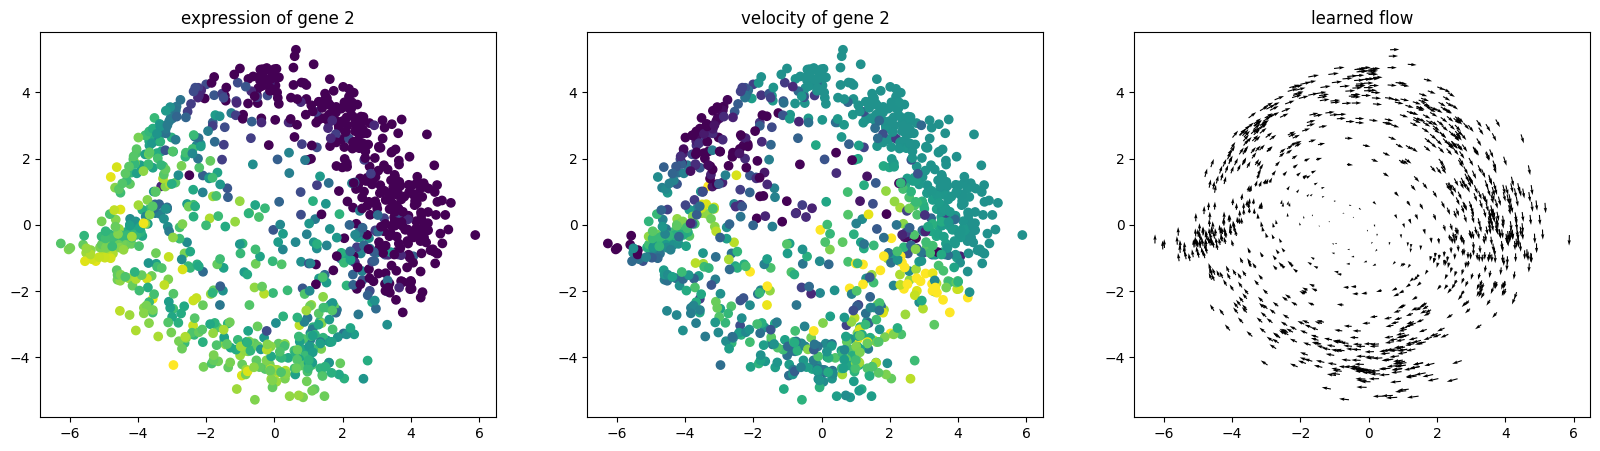

In [40]:
import scanpy as sc
plt.rcParams['figure.figsize'] = (20,5)
# Compute PCA
plt.subplot(131)
# sc.tl.pca(adata_subset, n_comps=2)
# sc.pp.neighbors(adata_subset)
# sc.tl.umap(adata_subset)

plt.scatter(adata.obsm["X_pca"][:,0],adata.obsm["X_pca"][:,1], c=X[2,:])
plt.title('expression of gene 2')

plt.subplot(132)
plt.scatter(adata.obsm["X_pca"][:,0],adata.obsm["X_pca"][:,1], c=V[2,:])
plt.title('velocity of gene 2')
plt.clim([-2,2])

plt.subplot(133)
plt.quiver(adata.obsm["X_pca"][:,0],adata.obsm["X_pca"][:,1],vs2[:,0],vs2[:,1])
plt.title('learned flow')


In [41]:
G = time_lagged_correlation(X,V,T)
print(np.dot( np.mean( ys_true[0:100,:],axis=0) - np.mean(ys_true[100:200,:],axis=0), vs2[1,:] )  )


# G_Granger,_ = time_lagged_Granger_CV_fast(X,V,T)


# if np.dot( np.mean( ys_true[0:100,:],axis=0) - np.mean(ys_true[100:200,:],axis=0), vs2[1,:] ) < 0:
if G[0,1] < G[1,0]:
    G = G.T
    
    # G_Granger = G_Granger.T
    print('reversed dynamics')

0.42931774


/var/folders/3c/t0768wrd4tzgkdw8827tgf3m0000gp/T/ipykernel_92717/1912920381.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  print(np.dot( np.mean( ys_true[0:100,:],axis=0) - np.mean(ys_true[100:200,:],axis=0), vs2[1,:] )  )


# Visualize network and ground truth

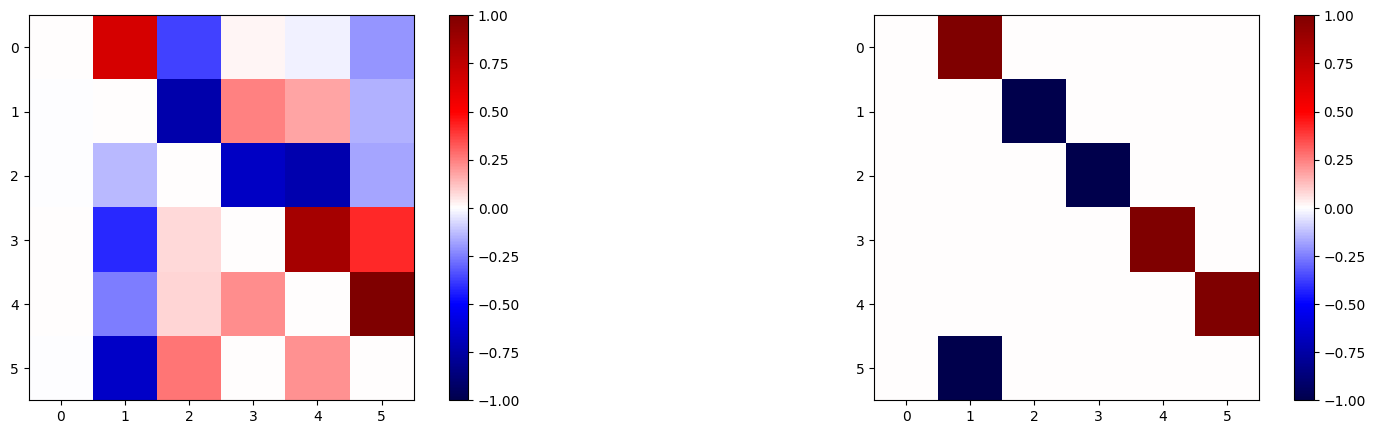

In [42]:
# G =  np.load('/Users/wenjunzhao/dropbox/cardamom/results_article/Benchmark_on_simulated_data/CycleData/CN5/CycleGRN/score_10.npy')
plt.subplot(121)
plt.imshow(G,cmap='seismic')
plt.clim([-1,1])
plt.colorbar()



truth = np.load('Data/True/inter_signed.npy')
plt.subplot(122)

plt.imshow(truth,cmap='seismic')
plt.clim([-1,1])
plt.colorbar()

# Compute AUPRC

In [44]:
# G =  np.load('/Users/wenjunzhao/dropbox/cardamom/results_article/Benchmark_on_simulated_data/CycleData/CN5/CycleGRN/score_10.npy')
# G = G.T
from sklearn.metrics import precision_recall_curve, auc
edges = [(i,j) for i in range(G.shape[0]) for j in set(range(1,G.shape[0]))-{i}]
y0 = np.array([truth[i,j] for (i,j) in edges])
y1 = np.array([G[i,j] for (i,j) in edges])
precision, recall, thresholds = precision_recall_curve(abs(y0), abs(y1) )
print(auc(recall,precision))


0.9061507936507937
